In [ ]:
import torch
from leap import LeapForCausalLM, LeapConfig
from lstm import LstmForCausalLM
from transformers import (PreTrainedTokenizerFast, TrainingArguments,
                          Trainer, default_data_collator,
                          GPT2Config, GPT2LMHeadModel)

from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
from torch.utils.data import Subset

# word level tokenizer as per wikitext modeling
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer

import math
import copy
from itertools import chain


import logging
logging.disable(logging.INFO)

In [ ]:
# globals
raw_datasets = load_dataset("wikitext", "wikitext-103-v1")
total_train_tokens = 105268829 # see appendix at the end of notebook
max_num_params = 69308416
param_data_ratio = max_num_params**.74 / total_train_tokens
seq_len = 1024
subset_datasets = raw_datasets

# hyperparameters
training_args = TrainingArguments(
    output_dir = "./results",
    logging_strategy = "steps",
    evaluation_strategy = "steps",
    save_strategy = "steps",
    logging_steps = 500,
    save_steps = 500,
    report_to = "none",
    learning_rate = 5e-4,
    lr_scheduler_type = "cosine",
    warmup_ratio = .05,
    num_train_epochs = 1,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 2,
    load_best_model_at_end = True,
    metric_for_best_model = "eval_loss",
    max_grad_norm = 1,
    fp16 = True,
)

Found cached dataset wikitext (C:/Users/micha/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


  0%|          | 0/3 [00:00<?, ?it/s]

# PREPROCESSING

In [ ]:
# make a word level tokenizer
tokenizer = Tokenizer(WordLevel(unk_token="<unk>"))
tokenizer.pre_tokenizer = Whitespace()
tokenizer.enable_padding(pad_id = 0, pad_token = "<pad>")
# no post processing

# only use vocab size of 8192 for reasonable speed/memory
token_trainer = WordLevelTrainer(vocab_size = 8191, # -1 for pad token
                                 special_tokens = ["<unk>"])

def batch_iterator(batch_size=10000):
    text = raw_datasets["train"]['text']
    for i in range(0, len(text), batch_size):
        yield text[i : i + batch_size]

tokenizer.train_from_iterator(batch_iterator(),
                              trainer = token_trainer,
                              length = len(raw_datasets["train"]["text"]))
tokenizer = PreTrainedTokenizerFast(tokenizer_object = tokenizer, pad_token = "<pad>")

# tokenized the dataset
def tokenize_function(examples):
    output = tokenizer(examples["text"])
    return output

# tokenize dataset
tokenized_datasets = raw_datasets.map(
    tokenize_function,
    batched = True,
    remove_columns = "text",
    desc = f"tokenize dataset",
    load_from_cache_file = True
)

def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: list(chain(*examples[k])) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])

    # Split by chunks of max_len
    result = {
        k: [t[i : i + seq_len] for i in range(0, total_length, seq_len)]
        for k, t in concatenated_examples.items()
    }
    
    # for language modeling, inputs are labels (they will be shifted inside the model)
    result["labels"] = result["input_ids"].copy()
    
    # pad last block with 0
    last_ids = result["input_ids"][-1]
    diff = seq_len - len(last_ids)
    result["input_ids"][-1] = last_ids + [0 for _ in range(diff)]
    
    # set attention mask to mask out these tokens
    result["attention_mask"][-1] = result["attention_mask"][-1] + [0 for _ in range(diff)]
    
    # set pad labels to -100 so they will be ignored by CrossEntropyLoss
    result["labels"][-1] = result["labels"][-1] + [-100 for _ in range(diff)]
    return result

# set globally block size for group texts function
lm_dataset = tokenized_datasets.map(
    group_texts,
    batched = True,
    batch_size = 10000,
    desc = f"Grouping texts in chunks of {seq_len}",
    load_from_cache_file = True
)

lm_dataset = lm_dataset.remove_columns(["token_type_ids"])

Loading cached processed dataset at C:/Users/micha/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-a2031eb206d20f87.arrow
Loading cached processed dataset at C:/Users/micha/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-8f3dd2e5d5819fe2.arrow
Loading cached processed dataset at C:/Users/micha/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-f4668efef485cbea.arrow
Loading cached processed dataset at C:/Users/micha/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-9004e9678f0a1614.arrow
Loading cached processed dataset at C:/Users/micha/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-d18

## helper function

In [ ]:
def subset_data(dataset, num_parameters, param_data_ratio):
    dataset = DatasetDict(copy.deepcopy(dataset))
    subset_num_tokens = num_parameters**.74 / param_data_ratio
    
    global seq_len
    num_rows = int(subset_num_tokens) // seq_len

    training_set = dataset["train"]
    dataset["train"] = Dataset.from_dict(training_set[:num_rows+1])
    
    real_num_tokens = len(dataset["train"]) * seq_len
    print(f'NUMBER OF TOKENS: {real_num_tokens}, with commas {real_num_tokens:,}')
    return dataset

# TRAINING FUNCTION

In [ ]:
def run_training(hidden_size, n_head = None, gpt = False, rnn = False):
    # calculate number of layers needed based on levine 2020
    n_layer = round((math.log(hidden_size) - 5.039) / 5.55e-2)
    n_layer = max(1, n_layer)
    print(f'Using {n_layer} layers')
    
    # get number of parameters
    if gpt is True:
        config = GPT2Config(
            n_embd = hidden_size, n_layer = n_layer,
            n_head = 1, vocab_size = 0, n_positions = 0
        )
        model = GPT2LMHeadModel(config)
    elif rnn is True:
        model = LstmForCausalLM(
            hidden_size = hidden_size,
            n_layer = n_layer,
            vocab_size = 0
        )
    else:
        config = LeapConfig(
            hidden_size = hidden_size, n_layer = n_layer,
            n_head = n_head, vocab_size = 0, n_positions = 0
        )
        model = LeapForCausalLM(config)

    non_embedding_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'NON EMBEDDING PARAMETERS: {non_embedding_parameters}, with commas {non_embedding_parameters:,}')

    # subset dataset using global lm_dataset
    global lm_dataset
    subset_datasets = subset_data(lm_dataset, non_embedding_parameters, param_data_ratio)

    if gpt is True:
        config = GPT2Config(
            n_embd = hidden_size, n_layer = n_layer, n_head = n_head,
            vocab_size = len(tokenizer) + 1, n_positions = seq_len,
            initializer_range = 1 / hidden_size**.5,
            resid_pdrop = 0, embd_pdrop = 0, attn_pdrop = 0 # no dropout bc one epoch
        )
        model = GPT2LMHeadModel(config)
    elif rnn is True:
        model = LstmForCausalLM(
            hidden_size = hidden_size,
            n_layer = n_layer,
            vocab_size = len(tokenizer) + 1,
            hidden_dropout_prob = 0
        )
    else:
        config = LeapConfig(
            hidden_size = hidden_size, n_layer = n_layer, n_head = n_head,
            vocab_size = len(tokenizer) + 1, n_positions = seq_len,
            use_local_att = True, window_sizes = None, rescale = 10,
            initializer_range = 1 / hidden_size**.5, hidden_dropout_prob = 0 # no dropout bc one epoch
        )
        model = LeapForCausalLM(config)

    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=default_data_collator,
        train_dataset=subset_datasets["train"],
        eval_dataset=subset_datasets["validation"],
    )

    trainer.train()
    
    print("\n===============TOTAL TRAINING FLOATING POINT OPERATIONS===============\n")
    print(f'Numeric form: {int(trainer.state.total_flos)}\nHuman Readable: {int(trainer.state.total_flos):,}')

    print("\n===============TEST SET CROSS ENTROPY LOSS EVALUATION===============\n")
    print(trainer.evaluate(subset_datasets["test"]))

    # save gpu memory
    del trainer
    del model
    del subset_datasets
    torch.cuda.empty_cache()

# GPT2 TRAINING
Each run is done seperately in it's own cell just for easy viewing of logs and in case something goes wrong (OOM errors or training issues). Note that the learning rate had to be lowered from 1e-3 to 5e-4 because gpt2 wasn't converging on the largest test and all tests redone

In [ ]:
run_training(hidden_size = 64, n_head = 1, gpt = True)

Using 1 layers
NON EMBEDDING PARAMETERS: 50112, with commas 50,112


C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


NUMBER OF TOKENS: 499712, with commas 499,712


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 150249406464
Human Readable: 150,249,406,464

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 6.038037300109863, 'eval_runtime': 0.7756, 'eval_samples_per_second': 306.864, 'eval_steps_per_second': 153.432, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 128, n_head = 2, gpt = True)

Using 1 layers
NON EMBEDDING PARAMETERS: 198528, with commas 198,528
NUMBER OF TOKENS: 1382400, with commas 1,382,400


Step,Training Loss,Validation Loss
500,5.923600,5.628588



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 1646670643200
Human Readable: 1,646,670,643,200

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 5.565395355224609, 'eval_runtime': 0.7777, 'eval_samples_per_second': 306.029, 'eval_steps_per_second': 153.015, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 160, n_head = 2, gpt = True)

Using 1 layers
NON EMBEDDING PARAMETERS: 309600, with commas 309,600


C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


NUMBER OF TOKENS: 1921024, with commas 1,921,024


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,5.871900,5.523679



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 3568494182400
Human Readable: 3,568,494,182,400

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 5.4598236083984375, 'eval_runtime': 0.7884, 'eval_samples_per_second': 301.859, 'eval_steps_per_second': 150.93, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 192, n_head = 3, gpt = True)

Using 4 layers
NON EMBEDDING PARAMETERS: 1779840, with commas 1,779,840


C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


NUMBER OF TOKENS: 7005184, with commas 7,005,184


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,5.880200,5.375783
1000,5.169800,5.121512
1500,5.002600,4.990281
2000,4.882700,4.893657
2500,4.810200,4.835835
3000,4.766800,4.809031



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 74808640143360
Human Readable: 74,808,640,143,360

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 4.734671592712402, 'eval_runtime': 1.4655, 'eval_samples_per_second': 162.4, 'eval_steps_per_second': 81.2, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 224, n_head = 4, gpt = True)

Using 7 layers
NON EMBEDDING PARAMETERS: 4235616, with commas 4,235,616


C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


NUMBER OF TOKENS: 13305856, with commas 13,305,856


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,5.934400,5.370236
1000,5.153100,5.088532
1500,4.973100,4.937986
2000,4.867700,4.858500
2500,4.770800,4.753085
3000,4.680800,4.669009
3500,4.598300,4.597792
4000,4.553300,4.530530
4500,4.474900,4.478220
5000,4.430700,4.430018



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 338150979403776
Human Readable: 338,150,979,403,776

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 4.317898750305176, 'eval_runtime': 2.5658, 'eval_samples_per_second': 92.757, 'eval_steps_per_second': 46.379, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 256, n_head = 4, gpt = True)

Using 9 layers
NON EMBEDDING PARAMETERS: 7108352, with commas 7,108,352


C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


NUMBER OF TOKENS: 19518464, with commas 19,518,464


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,5.947600,5.404133
1000,5.195800,5.097146
1500,4.990100,4.945464
2000,4.864600,4.837646
2500,4.778900,4.752940
3000,4.674500,4.662962
3500,4.593700,4.575736
4000,4.516000,4.498229
4500,4.429400,4.408222
5000,4.371200,4.340597



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 832464675667968
Human Readable: 832,464,675,667,968

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 3.996950387954712, 'eval_runtime': 3.2961, 'eval_samples_per_second': 72.207, 'eval_steps_per_second': 36.103, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 320, n_head = 5, gpt = True)

Using 13 layers


C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


NON EMBEDDING PARAMETERS: 16029120, with commas 16,029,120
NUMBER OF TOKENS: 35624960, with commas 35,624,960


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,5.984400,5.439550
1000,5.209500,5.141995
1500,5.006600,4.971425
2000,4.885900,4.854750
2500,4.795700,4.794035
3000,4.707500,4.697477
3500,4.610100,4.607020
4000,4.541200,4.522990
4500,4.468200,4.428399
5000,4.380500,4.349230



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 3426220553011200
Human Readable: 3,426,220,553,011,200

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 3.617107391357422, 'eval_runtime': 5.4826, 'eval_samples_per_second': 43.41, 'eval_steps_per_second': 21.705, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 448, n_head = 7, gpt = True)

Using 19 layers
NON EMBEDDING PARAMETERS: 45872064, with commas 45,872,064
NUMBER OF TOKENS: 77564928, with commas 77,564,928


Step,Training Loss,Validation Loss
500,6.031200,5.466364
1000,5.266000,5.190466
1500,5.057200,5.023293
2000,4.956300,4.945972
2500,4.876700,4.826606
3000,4.765500,4.740273
3500,4.697000,4.677341
4000,4.633700,4.622077
4500,4.576200,4.559217
5000,4.496700,4.482879



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 21348380048228352
Human Readable: 21,348,380,048,228,352

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 3.2382781505584717, 'eval_runtime': 10.8531, 'eval_samples_per_second': 21.929, 'eval_steps_per_second': 10.965, 'epoch': 1.0}


# LEAP TRAINING

In [ ]:
run_training(hidden_size = 64, n_head = 1)

C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Using 1 layers
NON EMBEDDING PARAMETERS: 49856, with commas 49,856
NUMBER OF TOKENS: 497664, with commas 497,664


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 148869218304
Human Readable: 148,869,218,304

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 6.114893913269043, 'eval_runtime': 0.8957, 'eval_samples_per_second': 265.72, 'eval_steps_per_second': 132.86, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 128, n_head = 2)

Using 1 layers
NON EMBEDDING PARAMETERS: 198016, with commas 198,016


C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


NUMBER OF TOKENS: 1380352, with commas 1,380,352


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,6.107800,5.784122



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 1639990689792
Human Readable: 1,639,990,689,792

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 5.721367835998535, 'eval_runtime': 0.8224, 'eval_samples_per_second': 289.388, 'eval_steps_per_second': 144.694, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 160, n_head = 2)

Using 1 layers
NON EMBEDDING PARAMETERS: 308960, with commas 308,960


c:\users\micha\desktop\leap\src\leap\LEAP.py:200: UserWarning: Using a hidden_size-to-head ratio of greater than 64 is not ideal as LEAP uses a simplified form of attention that relies on having many heads
  warnings.warn("Using a hidden_size-to-head ratio of greater than 64 is not ideal as"
C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


NUMBER OF TOKENS: 1917952, with commas 1,917,952


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,6.025500,5.665014



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 3555422699520
Human Readable: 3,555,422,699,520

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 5.601402282714844, 'eval_runtime': 0.8223, 'eval_samples_per_second': 289.432, 'eval_steps_per_second': 144.716, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 192, n_head = 3)

Using 4 layers
NON EMBEDDING PARAMETERS: 1776768, with commas 1,776,768


C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


NUMBER OF TOKENS: 6995968, with commas 6,995,968


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,6.088100,5.521639
1000,5.237200,5.147675
1500,4.968400,4.943083
2000,4.832500,4.823637
2500,4.733700,4.751712
3000,4.679500,4.720037



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 74581272428544
Human Readable: 74,581,272,428,544

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 4.645600318908691, 'eval_runtime': 1.5258, 'eval_samples_per_second': 155.988, 'eval_steps_per_second': 77.994, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 224, n_head = 4)

Using 7 layers
NON EMBEDDING PARAMETERS: 4229344, with commas 4,229,344


C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


NUMBER OF TOKENS: 13291520, with commas 13,291,520


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,6.155500,5.549298
1000,5.256500,5.126582
1500,4.980900,4.891197
2000,4.780600,4.744344
2500,4.655000,4.643302
3000,4.566100,4.545161
3500,4.485700,4.473008
4000,4.426700,4.422051
4500,4.375600,4.377839
5000,4.333000,4.350260



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 337286462177280
Human Readable: 337,286,462,177,280

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 4.252130031585693, 'eval_runtime': 2.175, 'eval_samples_per_second': 109.426, 'eval_steps_per_second': 54.713, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 256, n_head = 4)

Using 9 layers
NON EMBEDDING PARAMETERS: 7099136, with commas 7,099,136


C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


NUMBER OF TOKENS: 19499008, with commas 19,499,008


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,6.206400,5.578196
1000,5.279000,5.132071
1500,4.963200,4.885261
2000,4.777000,4.734221
2500,4.647800,4.624836
3000,4.525700,4.528377
3500,4.448600,4.438150
4000,4.387900,4.363996
4500,4.321800,4.311187
5000,4.262100,4.262807



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 830556657942528
Human Readable: 830,556,657,942,528

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 4.007962703704834, 'eval_runtime': 2.5397, 'eval_samples_per_second': 93.712, 'eval_steps_per_second': 46.856, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 320, n_head = 5)

Using 13 layers
NON EMBEDDING PARAMETERS: 16012480, with commas 16,012,480


C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


NUMBER OF TOKENS: 35598336, with commas 35,598,336


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,6.234500,5.631526
1000,5.340800,5.209981
1500,5.026300,4.926128
2000,4.796500,4.755405
2500,4.654400,4.624541
3000,4.545600,4.527535
3500,4.442900,4.407835
4000,4.361500,4.329208
4500,4.290500,4.259641
5000,4.221200,4.212588



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 3420105859399680
Human Readable: 3,420,105,859,399,680

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 3.68304181098938, 'eval_runtime': 3.6836, 'eval_samples_per_second': 64.61, 'eval_steps_per_second': 32.305, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 448, n_head = 7)

Using 19 layers


C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


NON EMBEDDING PARAMETERS: 45838016, with commas 45,838,016
NUMBER OF TOKENS: 77522944, with commas 77,522,944


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,6.327500,5.716834
1000,5.448100,5.326819
1500,5.160700,5.080652
2000,4.992200,4.923663
2500,4.814300,4.772987
3000,4.679600,4.605647
3500,4.544300,4.492287
4000,4.442400,4.409285
4500,4.360400,4.323043
5000,4.276600,4.250167



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 21320987684634624
Human Readable: 21,320,987,684,634,624

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 3.329268217086792, 'eval_runtime': 6.8597, 'eval_samples_per_second': 34.695, 'eval_steps_per_second': 17.348, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 512, n_head = 8)

C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Using 22 layers
NON EMBEDDING PARAMETERS: 69308416, with commas 69,308,416
NUMBER OF TOKENS: 102674432, with commas 102,674,432


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,6.327900,5.709722
1000,5.474200,5.348254
1500,5.168500,5.094281
2000,4.998900,5.005149
2500,4.891400,4.878734
3000,4.770500,4.716152
3500,4.637200,4.609263
4000,4.519500,4.470326
4500,4.426500,4.394495
5000,4.345100,4.320373



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 42697213473718272
Human Readable: 42,697,213,473,718,272

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 3.2232205867767334, 'eval_runtime': 8.8866, 'eval_samples_per_second': 26.782, 'eval_steps_per_second': 13.391, 'epoch': 1.0}


# Parameter scaling

<ipython-input-5-ca540c53d32f>:58: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a
<ipython-input-5-ca540c53d32f>:58: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


GPT2 42932915937791.516 0.08903330047720337 2.585
LEAP 28363515245975.594 0.09174780961091501 2.562


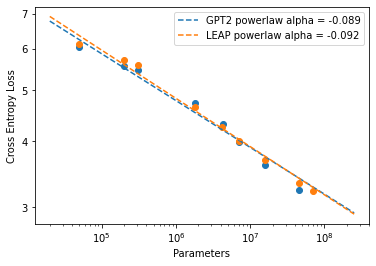

In [ ]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

gpt2_param = np.array([
    50112,
    198528,
    309600,
    1779840,
    4235616,
    7108352,
    16029120,
    45872064,
], dtype = 'int64')

gpt2_y = np.array([
    6.038,
    5.565,
    5.46,
    4.735,
    4.318,
    3.997,
    3.61,
    3.23,
])

leap_param = np.array([
    49856,
    198016,
    308960,
    1776768,
    4229344,
    7099136,
    16012480,
    45838016,
    69308416,
], dtype = 'int64')

leap_y = np.array([
    6.115,
    5.721,
    5.601,
    4.646,
    4.252,
    4.008,
    3.683,
    3.329,
    3.223,
])

lstm_x = np.array([
])

lstm_y = np.array([
])

def powerlaw(n, n_c, a):
    return (n_c / n)**a

x = 10**np.arange(start = 4.3, stop = 8.5, step = .1, dtype = 'float64')

plt.loglog()
plt.yticks([2, 3, 4, 5, 6, 7], labels = [2, 3, 4, 5, 6, 7])

plt.scatter(x = gpt2_param, y = gpt2_y)
(n_c, a), _ = curve_fit(powerlaw, gpt2_param, gpt2_y, maxfev=10000, p0 = np.array([9e13, .076]))
plt.plot(x, powerlaw(x, n_c, a), label = f'GPT2 powerlaw alpha = {-a:.3}', linestyle = '--')
print("GPT2", n_c, a, f'{powerlaw(10**9, n_c, a):.4}')

plt.scatter(x = leap_param, y = leap_y)
(n_c, a), _ = curve_fit(powerlaw, leap_param, leap_y, maxfev=10000, p0 = np.array([9e13, .076]))
plt.plot(x, powerlaw(x, n_c, a), label = f'LEAP powerlaw alpha = {-a:.2}', linestyle = '--')
print("LEAP", n_c, a, f'{powerlaw(10**9, n_c, a):.4}')

plt.xlabel("Parameters")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.savefig('param_scale.png', dpi = 100)
plt.show()

# Compute Scaling

<ipython-input-2-84fbe372e4c9>:58: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a
<ipython-input-2-84fbe372e4c9>:58: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


GPT2 5.2206617991817826e+26 0.05117541902611786 8.067
LEAP 2.4920167331379797e+26 0.05276556024262718 8.278


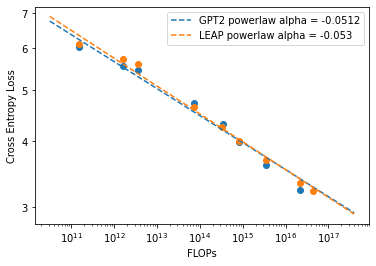

In [ ]:
gpt2_flos = np.array([
    150249406464,
    1646670643200,
    3568494182400,
    74808640143360,
    338150979403776,
    832464675667968,
    3426220553011200,
    21348380048228352,
], dtype = 'int64')

leap_flos = np.array([
    148869218304,
    1639990689792,
    3555422699520,
    74581272428544,
    337286462177280,
    830556657942528,
    3420105859399680,
    21320987684634624,
    42697213473718272,
], dtype = 'int64')

x = 10**np.arange(start = 10.5, stop = 17.7, step = .1, dtype = 'float64')
plt.loglog()
plt.yticks([3, 4, 5, 6, 7], labels = [3, 4, 5, 6, 7])

#plt.plot(gpt2_flos, gpt2_y, ".-", color = 'C0', label = "GPT2 linear interpolation", markersize = 10)
plt.scatter(x = gpt2_flos, y = gpt2_y)
(n_c, a), _ = curve_fit(powerlaw, gpt2_flos, gpt2_y, maxfev=10000, p0 = np.array([9e30, .05]))
plt.plot(x, powerlaw(x, n_c, a), label = f'GPT2 powerlaw alpha = {-a:.3}', linestyle = '--')
print("GPT2", n_c, a, f'{powerlaw(10**9, n_c, a):.4}')

#plt.plot(leap_flos, leap_y, ".-", color = 'C1', label = "LEAP linear interpolation", markersize = 10)
plt.scatter(x = leap_flos, y = leap_y)
(n_c, a), _ = curve_fit(powerlaw, leap_flos, leap_y, maxfev=10000, p0 = np.array([9e30, .05]))
plt.plot(x, powerlaw(x, n_c, a), label = f'LEAP powerlaw alpha = {-a:.2}', linestyle = '--')
print("LEAP", n_c, a, f'{powerlaw(10**9, n_c, a):.4}')

plt.xlabel("FLOPs")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.savefig('compute_scale.png', dpi = 100)
plt.show()

# APPENDIX

In [ ]:
import re

# to count tokens, comes from https://huggingface.co/docs/tokenizers/components
whitespace_regex = re.compile("\w+|[^\w\s]+")

# get number of tokens
total_tokens = 0
for row in raw_datasets["train"]["text"]:
    total_tokens += len((whitespace_regex.split(row)))
total_tokens

105268829

# LSTM TRAINING

In [ ]:
run_training(hidden_size = 64, rnn = True)

Using 1 layers
NON EMBEDDING PARAMETERS: 33408, with commas 33,408


C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
C:\Users\micha\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


NUMBER OF TOKENS: 369664, with commas 369,664


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 74098409472
Human Readable: 74,098,409,472

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 15.131314277648926, 'eval_runtime': 3.2103, 'eval_samples_per_second': 74.137, 'eval_steps_per_second': 37.068, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 96, rnn = True)

Using 1 layers
NON EMBEDDING PARAMETERS: 74688, with commas 74,688
NUMBER OF TOKENS: 670720, with commas 670,720


Step,Training Loss,Validation Loss



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 300568412160
Human Readable: 300,568,412,160

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 10.494235038757324, 'eval_runtime': 3.5429, 'eval_samples_per_second': 67.177, 'eval_steps_per_second': 33.589, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 128, rnn = True)

Using 1 layers
NON EMBEDDING PARAMETERS: 132352, with commas 132,352
NUMBER OF TOKENS: 1024000, with commas 1,024,000


Step,Training Loss,Validation Loss
500,13.526600,8.492445



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 813170688000
Human Readable: 813,170,688,000

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 8.3527250289917, 'eval_runtime': 3.4871, 'eval_samples_per_second': 68.252, 'eval_steps_per_second': 34.126, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 160, rnn = True)

Using 1 layers
NON EMBEDDING PARAMETERS: 206400, with commas 206,400


C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
C:\Users\micha\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


NUMBER OF TOKENS: 1423360, with commas 1,423,360


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,13.012000,7.334210



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 1762689024000
Human Readable: 1,762,689,024,000

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 7.193444728851318, 'eval_runtime': 3.7914, 'eval_samples_per_second': 62.774, 'eval_steps_per_second': 31.387, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 192, rnn = True)

Using 4 layers
NON EMBEDDING PARAMETERS: 1186176, with commas 1,186,176


C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


NUMBER OF TOKENS: 5188608, with commas 5,188,608


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,14.231200,6.937136
1000,6.190400,5.915351
1500,5.678500,5.660433
2000,5.502000,5.531826
2500,5.436800,5.505051



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 36927613698048
Human Readable: 36,927,613,698,048

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 5.423725605010986, 'eval_runtime': 12.5413, 'eval_samples_per_second': 18.977, 'eval_steps_per_second': 9.489, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 224, rnn = True)

In [ ]:
run_training(hidden_size = 256, rnn = True)

In [ ]:
run_training(hidden_size = 320, rnn = True)

In [ ]:
run_training(hidden_size = 448, rnn = True)